# Testing basic keras model layers

## Dependencies import

In [7]:
import pickle
import pandas as pd
import os
import numpy as np
import shutil

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report,confusion_matrix

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , Convolution2D, MaxPool2D,MaxPooling2D , Flatten , Dropout , BatchNormalization,Activation

from keras.constraints import maxnorm
from keras import utils as np_utils
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint,EarlyStopping
from keras.optimizers import SGD, adam

import matplotlib.pyplot as plt
import seaborn as sns


# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

In [8]:
def Directory_Data_Split(Batch_path,Split_files):
    
    Split_Type = ['X_Train', 'X_Val', 'X_Test']
    if not os.path.exists(Batch_path):
        os.mkdir(Batch_path)
    os.chdir(Batch_path)
    for index,item in enumerate(Split_Type):
        Split_folder = os.path.join(Batch_path,Split_Type[index])
        if not os.path.exists(Split_folder):
            os.mkdir(Split_folder)
        os.chdir(Split_folder)
        seeds = Split_files[item]
        for index,row in seeds.iterrows():
            shutil.copy(row['File_path'],Split_folder+'/'+row['File_name'])
    os.chdir(Batch_path)
    
# path = '/mnt/ST079-00/ST079-00-01/Input/X_Ray_Split'
# Data_Split(path,Split_data)

def Model_accuracy_graph(history,name,filepath):
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    os.chdir(filepath)
# summarize history for accuracy    
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(name+'-model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.savefig(name+'-model accuracy.png',bbox_inches='tight')
# summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(name+'-model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.savefig(name+'-model loss.png',bbox_inches='tight')

def Model_Save(model,filename,filepath):
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    os.chdir(filepath)
    pickle.dump(model, open(filename, 'wb'))

    
    
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=4, mode='min')
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)

In [9]:
File_Data = pd.read_csv('File and UT data.csv')

In [10]:
dict = {1: 'Normal', 2: 'Small',3:'Weak', 4: 'Abnormal', 5: 'NonGerm'}
File_Data['UT_Name'] = File_Data['UT'].apply(lambda label: dict[label])
File_Data.head()

,Unnamed: 0,Col_ID,Row_ID,UT,Well_ID,Plate_ID,UT_Tray_ID,Crop_ID,Seed_ID,File_name,File_path,UT_Name
0,0,1,F,1,F-1,1,1,KWM01_Train_1_2,KWM01_TRAIN_01.dcm-F-1-segmented.tif,KWM01_TRAIN_01.dcm-F-1-segmented.tif,/mnt/ST079-00/ST079-00-01/Input/X-Ray_Files/KW...,Normal
1,1,1,E,1,E-1,1,1,KWM01_Train_1_2,KWM01_TRAIN_01.dcm-E-1-segmented.tif,KWM01_TRAIN_01.dcm-E-1-segmented.tif,/mnt/ST079-00/ST079-00-01/Input/X-Ray_Files/KW...,Normal
2,2,1,D,1,D-1,1,1,KWM01_Train_1_2,KWM01_TRAIN_01.dcm-D-1-segmented.tif,KWM01_TRAIN_01.dcm-D-1-segmented.tif,/mnt/ST079-00/ST079-00-01/Input/X-Ray_Files/KW...,Normal
3,3,1,C,1,C-1,1,1,KWM01_Train_1_2,KWM01_TRAIN_01.dcm-C-1-segmented.tif,KWM01_TRAIN_01.dcm-C-1-segmented.tif,/mnt/ST079-00/ST079-00-01/Input/X-Ray_Files/KW...,Normal
4,4,1,B,3,B-1,1,1,KWM01_Train_1_2,KWM01_TRAIN_01.dcm-B-1-segmented.tif,KWM01_TRAIN_01.dcm-B-1-segmented.tif,/mnt/ST079-00/ST079-00-01/Input/X-Ray_Files/KW...,Weak


## Train, Test and Validation data split based on distribution (Stratified separation)

In [13]:
X = File_Data.loc[:, File_Data.columns != 'UT_Name']
Y = File_Data['UT_Name']
X_Train, x_test, Y_Train, y_test = train_test_split(X,Y, test_size=0.3, random_state=42, shuffle=True, stratify=Y)
X_Val,X_Test,Y_Val,Y_Test = train_test_split(x_test,y_test, test_size=0.5, random_state=42, shuffle=True, stratify=y_test)

X_Train = X_Train.assign(UT_Name=Y_Train)
X_Test = X_Test.assign(UT_Name=Y_Test)
X_Val = X_Val.assign(UT_Name=Y_Val)

Split_data = {'X_Train':X_Train, 'X_Val':X_Val, 'X_Test':X_Test}

## Image Importer (No Need to create new folder)

In [14]:
train_datagen = ImageDataGenerator(rescale=1/255.,zoom_range = 0.1,rotation_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1)
val_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
X_ray_filepath = '/mnt/ST079-00/ST079-00-01/Input/X-Ray_Files'

In [15]:
train_generator=train_datagen.flow_from_dataframe(dataframe=Split_data['X_Train'],
                                                  directory=X_ray_filepath,
                                                  x_col="File_name",
                                                  y_col="UT_Name",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(224,224))


valid_generator=val_datagen.flow_from_dataframe(dataframe=Split_data['X_Val'],
                                                  directory=X_ray_filepath,
                                                  x_col="File_name",
                                                  y_col="UT_Name",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(224,224))

test_generator=val_datagen.flow_from_dataframe(dataframe=Split_data['X_Test'],
                                                  directory=X_ray_filepath,
                                                  x_col="File_name",
                                                  y_col=None,
                                                  batch_size=1,
                                                  class_mode=None,
                                                  target_size=(224,224))

Found 1833 images belonging to 5 classes.
Found 402 images belonging to 5 classes.
Found 403 images.


## Creating Class Weights based on distribution

In [16]:
row = File_Data['UT']
dict = {1: 0, 2: 1,3:2, 4: 3, 5: 4}
row = row.apply(lambda label: dict[label])
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(row),
                                                 row)
del dict,row
class_weights


array([0.34133333, 2.59710145, 5.21941748, 1.44128686, 1.25023256])

## Test Model 1

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(224,224,3), use_bias=True))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv2D(32,(3, 3),use_bias=False,strides=2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('tanh'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
Model_1 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,class_weight=class_weights,
                    epochs=30)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
57/57 [==============================] - 105s 2s/step - loss: 1.2734 - acc: 0.5696 - val_loss: 1.9658 - val_acc: 0.1562
Epoch 2/30
57/57 [==============================] - 102s 2s/step - loss: 1.2059 - acc: 0.5862 - val_loss: 1.3331 - val_acc: 0.5838
Epoch 3/30
57/57 [==============================] - 101s 2s/step - loss: 1.1990 - acc: 0.5890 - val_loss: 1.6331 - val_acc: 0.1459
Epoch 4/30
57/57 [==============================] - 101s 2s/step - loss: 1.2184 - acc: 0.5747 - val_loss: 1.3562 - val_acc: 0.5676
Epoch 5/30
57/57 [==============================] - 100s 2s/step - loss: 1.1948 - acc: 0.5901 - val_loss: 1.5066 - val_acc: 0.1568
Epoch 6/30
57/57 [==============================] - 100s 2s/step - loss: 1.1977 - acc: 0.5892 - val_loss: 3.0230 - val_acc: 0.5459
Epoch 7/30
57/57 [==============================] - 101s 2s/step - loss: 1.2122 - acc: 0.5742 - val_loss: 2.6302 - val_acc: 0.1486
Epoch 8/30
57/57 [=================

In [19]:
print(Model_1.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


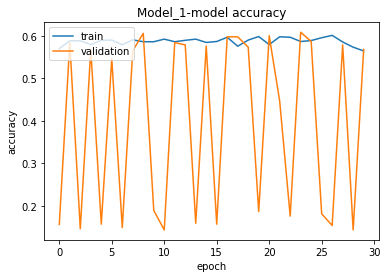

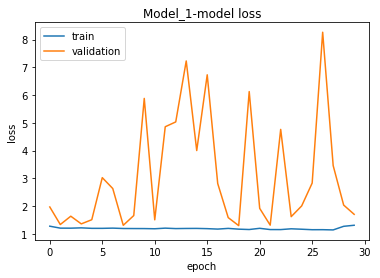

<Figure size 432x288 with 0 Axes>

In [22]:
Save_graph_path ='/mnt/ST079-00/ST079-00-01/Output/DL_Models_graphs'
model_name  = 'Model_1'
Model_accuracy_graph(Model_1,model_name,Save_graph_path)
Save_model_path = '/mnt/ST079-00/ST079-00-01/Output/DL_Models'
Model_Save(Model_1,model_name,Save_model_path)

### Model_1 -  Huge Difference in Test and Validation accuracy

## Test Model 2

In [23]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(224,224,3), use_bias=True))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv2D(32, (3, 3),use_bias=False,strides=2))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('tanh'))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])



In [24]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
Model_2 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,class_weight=class_weights,
                    epochs=30
)

Epoch 1/30
57/57 [==============================] - 103s 2s/step - loss: 1.3405 - acc: 0.5320 - val_loss: 2.0380 - val_acc: 0.6081
Epoch 2/30
57/57 [==============================] - 100s 2s/step - loss: 1.2835 - acc: 0.5618 - val_loss: 2.7262 - val_acc: 0.4784
Epoch 3/30
57/57 [==============================] - 101s 2s/step - loss: 1.2850 - acc: 0.5637 - val_loss: 1.7086 - val_acc: 0.5730
Epoch 4/30
57/57 [==============================] - 100s 2s/step - loss: 1.2304 - acc: 0.5862 - val_loss: 1.5880 - val_acc: 0.1676
Epoch 5/30
57/57 [==============================] - 100s 2s/step - loss: 1.2183 - acc: 0.5843 - val_loss: 1.4719 - val_acc: 0.6027
Epoch 6/30
57/57 [==============================] - 100s 2s/step - loss: 1.2230 - acc: 0.5742 - val_loss: 1.4044 - val_acc: 0.3622
Epoch 7/30
57/57 [==============================] - 100s 2s/step - loss: 1.2375 - acc: 0.5750 - val_loss: 1.7206 - val_acc: 0.5811
Epoch 8/30
57/57 [==============================] - 100s 2s/step - loss: 1.1861 - a

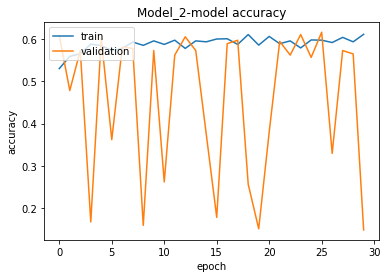

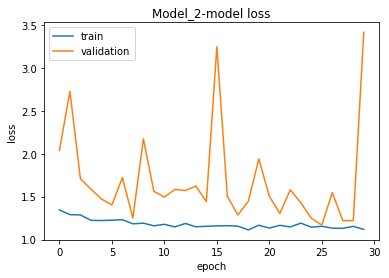

<Figure size 432x288 with 0 Axes>

In [25]:
Save_graph_path ='/mnt/ST079-00/ST079-00-01/Output/DL_Models_graphs'
model_name  = 'Model_2'
Model_accuracy_graph(Model_2,model_name,Save_graph_path)
Save_model_path = '/mnt/ST079-00/ST079-00-01/Output/DL_Models'
Model_Save(Model_2,model_name,Save_model_path)

### Model_2 Huge Difference in Train and Validation accuracy

## Test Model 3

In [26]:
model = Sequential()
model.add(Conv2D(input_shape=(224,224,3), filters=32, use_bias=True, kernel_size=(3,3)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, use_bias=False, kernel_size=(5,5), strides=2))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(5, activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
Model_3 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,class_weight=class_weights,
                    epochs=30
)

Epoch 1/30
57/57 [==============================] - 160s 3s/step - loss: 6.7503 - acc: 0.5681 - val_loss: 6.7086 - val_acc: 0.5838
Epoch 2/30
57/57 [==============================] - 156s 3s/step - loss: 6.7969 - acc: 0.5783 - val_loss: 6.5900 - val_acc: 0.5911
Epoch 3/30
57/57 [==============================] - 157s 3s/step - loss: 6.6384 - acc: 0.5881 - val_loss: 6.6651 - val_acc: 0.5865
Epoch 4/30
57/57 [==============================] - 157s 3s/step - loss: 6.5675 - acc: 0.5925 - val_loss: 6.6651 - val_acc: 0.5865
Epoch 5/30
57/57 [==============================] - 156s 3s/step - loss: 6.7710 - acc: 0.5799 - val_loss: 6.5779 - val_acc: 0.5919
Epoch 6/30
57/57 [==============================] - 156s 3s/step - loss: 6.6957 - acc: 0.5846 - val_loss: 6.5779 - val_acc: 0.5919
Epoch 7/30
57/57 [==============================] - 155s 3s/step - loss: 6.5586 - acc: 0.5931 - val_loss: 6.6215 - val_acc: 0.5892
Epoch 8/30
57/57 [==============================] - 155s 3s/step - loss: 6.7175 - a

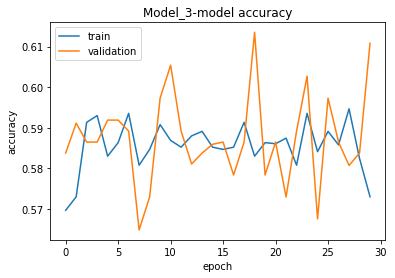

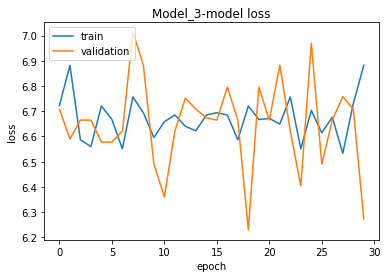

<Figure size 432x288 with 0 Axes>

In [28]:
Save_graph_path ='/mnt/ST079-00/ST079-00-01/Output/DL_Models_graphs'
model_name  = 'Model_3'
Model_accuracy_graph(Model_3,model_name,Save_graph_path)
Save_model_path = '/mnt/ST079-00/ST079-00-01/Output/DL_Models'
Model_Save(Model_3,model_name,Save_model_path)

### Model 3: Comaprable Train and validation Accuracy -  might imporve performance if tuned

## Test Model 4

In [ ]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, input_shape=(224,224,3), activation='relu', border_mode='same'))
model.add(Convolution2D(32, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(Convolution2D(64, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(Convolution2D(128, 3, 3, activation='relu', border_mode='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Convolution2D(256, 3, 3, activation='relu', border_mode='same'))
model.add(Convolution2D(256, 3, 3, activation='relu', border_mode='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu', W_constraint=maxnorm(3)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(224, 224,..., activation="relu", padding="same")`
  
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  import sys
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the 

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
Model_4 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,class_weight=class_weights,
                    epochs=30
)

Epoch 1/30
57/57 [==============================] - 377s 7s/step - loss: 2.2829 - acc: 0.2745 - val_loss: 2.8134 - val_acc: 0.4189
Epoch 2/30
57/57 [==============================] - 377s 7s/step - loss: 1.8289 - acc: 0.3920 - val_loss: 2.4259 - val_acc: 0.5649
Epoch 3/30
57/57 [==============================] - 372s 7s/step - loss: 1.6554 - acc: 0.4653 - val_loss: 2.2704 - val_acc: 0.1351
Epoch 4/30
57/57 [==============================] - 373s 7s/step - loss: 1.5849 - acc: 0.4801 - val_loss: 5.3676 - val_acc: 0.1432
Epoch 5/30
57/57 [==============================] - 375s 7s/step - loss: 1.5487 - acc: 0.4944 - val_loss: 3.8294 - val_acc: 0.5459
Epoch 6/30
57/57 [==============================] - 373s 7s/step - loss: 1.5100 - acc: 0.4966 - val_loss: 1.6654 - val_acc: 0.4946
Epoch 7/30
57/57 [==============================] - 373s 7s/step - loss: 1.4588 - acc: 0.5048 - val_loss: 3.4532 - val_acc: 0.5757
Epoch 8/30
57/57 [==============================] - 374s 7s/step - loss: 1.4323 - a

In [ ]:
Save_graph_path ='/mnt/ST079-00/ST079-00-01/Output/DL_Models_graphs'
model_name  = 'Model_4'
Model_accuracy_graph(Model_4,model_name,Save_graph_path)
Save_model_path = '/mnt/ST079-00/ST079-00-01/Output/DL_Models'
Model_Save(Model_4,model_name,Save_model_path)

## Test Model 5

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(224,224,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
Model_5 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,class_weight=class_weights,)

In [ ]:
Save_graph_path ='/mnt/ST079-00/ST079-00-01/Output/DL_Models_graphs'
model_name  = 'Model_5'
Model_accuracy_graph(Model_5,model_name,Save_graph_path)
Save_model_path = '/mnt/ST079-00/ST079-00-01/Output/DL_Models'
Model_Save(Model_5,model_name,Save_model_path)

## Testing Model 6

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(224,224,3)))
model.add(Conv2D(64, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2 ,2)))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(Dropout(0.1))
model.add(Conv2D(128, (3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(390625))
model.add(Dense(625))
model.add(Dense(25))
model.add(Dense(5, activation='softmax'))
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
Model_6 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,class_weight=class_weights)

In [ ]:
Save_graph_path ='/mnt/ST079-00/ST079-00-01/Output/DL_Models_graphs'
model_name  = 'Model_6'
Model_accuracy_graph(Model_6,model_name,Save_graph_path)
Save_model_path = '/mnt/ST079-00/ST079-00-01/Output/DL_Models'
Model_Save(Model_6,model_name,Save_model_path)

## Test Model 7 (Deeper Models)

In [ ]:
# Create the model
num_classes =5
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))
# Compile model
epochs = 30
lrate = 0.01
decay = lrate/epochs
sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
Model_7 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,class_weight=class_weights)

In [ ]:
Save_graph_path ='/mnt/ST079-00/ST079-00-01/Output/DL_Models_graphs'
model_name  = 'Model_7'
Model_accuracy_graph(Model_7,model_name,Save_graph_path)
Save_model_path = '/mnt/ST079-00/ST079-00-01/Output/DL_Models'
Model_Save(Model_7,model_name,Save_model_path)

## Test Model 8

In [ ]:
# Create the model
num_classes =5
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2))
          
model.add(SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2))) 

model.add(SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2))) 
          
model.add(SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Dropout(rate=0.1)
model.add(SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Dropout(rate=0.2)          
model.add(SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
          
model.add(SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(Dropout(rate=0.3)
model.add(SeparableConv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

          
model.add(Flatten())          
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(rate=0.4))
model.add(Dense(units=1024, activation='relu'))
model.add(Dropout(rate=0.3))
model.add(Dense(units=512, activation='relu'))    
model.add(Dropout(rate=0.2))
model.add(Dense(units=256, activation='relu'))    
model.add(Dropout(rate=0.1))
model.add(Dense(units=128, activation='relu'))    
model.add(Dropout(rate=0.05))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=5, activation='sigmoid'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
Model_8 = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30,class_weight=class_weights)

In [ ]:
Save_graph_path ='/mnt/ST079-00/ST079-00-01/Output/DL_Models_graphs'
model_name  = 'Model_8'
Model_accuracy_graph(Model_8,model_name)
Save_model_path = '/mnt/ST079-00/ST079-00-01/Output/DL_Models'
Model_Save(Model_8,model_name,Save_model_path)

## Transfer learning with VGG16

In [ ]:

def pretrained(model_name,save_path=None,save_name=None):
    model = model_name
    model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
    if save_name is not None:
        filename = save_name
        pickle.dump(model, open(filename, 'wb'))
    return(model)

In [ ]:
pretrained_model = pretrained(VGG16(),'vgg-edited.sav')

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

In [ ]:
model_1 = Model(inputs=pretrained_model.input, outputs=model(pretrained_model.output))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
Model_9 = model_1.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,class_weight=class_weights,
                    epochs=50
)

In [ ]:
Save_graph_path ='/mnt/ST079-00/ST079-00-01/Output/DL_Models_graphs'
model_name  = 'Model_9'
Model_accuracy_graph(Model_9,model_name,Save_graph_path)
Save_model_path = '/mnt/ST079-00/ST079-00-01/Output/DL_Models'
Model_Save(Model_9,model_name,Save_model_path)

## Test Model 10

In [ ]:
# CNN Model

model = Sequential()
model.add(Conv2D(filters=16,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))

model.add(Conv2D(filters=36,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units=64,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=5,activation='sigmoid'))

model.compile(optimizer='adam',loss=keras.losses.binary_crossentropy,metrics=['accuracy'])

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
Model_10 = model_1.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,class_weight=class_weights,
                    epochs=50
)

In [ ]:
Save_graph_path ='/mnt/ST079-00/ST079-00-01/Output/DL_Models_graphs'
model_name  = 'Model_10'
Model_accuracy_graph(Model_10,model_name,Save_graph_path)
Save_model_path = '/mnt/ST079-00/ST079-00-01/Output/DL_Models'
Model_Save(Model_10,model_name,Save_model_path)

## Testing incase of high performance

In [ ]:
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
predicted_class_indices
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
results.to_csv("results.csv",index=False)